<a href="https://colab.research.google.com/github/hnamtang/radar-cheatsheet/blob/main/radar_cheatsheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Interactive Radar Cheatsheet

This Python notebook can be used as a reference for some of the most common radar engineering equations.
It also provides the ability to play around with the concepts yourself and plug in real-world values.

More sections will be added as videos release in [The Animated Radar Cheatsheet YouTube series](https://tinyurl.com/radar-cheatsheet-playlist).

> Provided as supplemental material for [Marshall Bruner](https://tinyurl.com/marshall-bruner-yt)'s [series: The Animated Radar Cheatsheet](https://tinyurl.com/radar-cheatsheet-playlist).

- [GitHub](https://tinyurl.com/github-nb)
- [YouTube](https://tinyurl.com/marshall-bruner-yt-nb)

## References

- [Radar Handbook (book by Skolnik)](https://tinyurl.com/skolnik-radar-handbook)
- [Introduction to Radar Systems, Lecture 2: Radar Equation (course slides by MIT LL)](https://tinyurl.com/mit-radar-equation)


In [ ]:
import numpy as np
from scipy.constants import c, pi, foot, mile, nautical_mile, Boltzmann
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import fft2, fft, fftshift

plt.style.use("ggplot")
# plt.rcParams.update(
    # {
    #     "text.usetex": True,
    #     "font.family": "typeface",
    # }
# )  # Makes plotting slightly slower but prettier (requires LaTeX installed)

## A Note on Decibels (dB)

> This is by no means an exhaustive explanation.
Please see this [All About Circuits article](https://www.allaboutcircuits.com/textbook/radio-frequency-analysis-design/rf-principles-components/the-rf-engineers-guide-to-the-decibel) or one of the many other explanations.
I will most likely also make a video on this concept as it can be pretty confusing when starting out.

RF engineers often represent relative powers, voltages, and gains on the decibel scale because of how it lends itself to easy math and better visualization.

Key points to understand:
- Decibels are relative measurements, not absolute values
- They allow for compressing of large ranges of values into more manageable numbers
- The logarithmic scale means each 10 dB represents a 10-fold change in power

Practical applications in RF engineering:
1. Signal Strength Comparison
    - Instead of saying a signal is 1,000,000 times stronger, you can simply say it's 60 dB stronger
    - This makes complex calculations and comparisons much easier
2. Gain and Loss Calculations
    - Amplifiers are rated in dB gain
    - Transmission lines and components have loss characteristics measured in dB
    - You can easily add or subtract dB values to determine total system performance


A change in power or voltage can be described by the following equations:

\begin{equation}
\text{Power Ratio (dB)} = 10 * \log_{10}{(\frac{P_2}{P_1})}
\end{equation}

\begin{equation}
\text{Voltage Ratio (dB)} = 20 * \log_{10}{(\frac{V_2}{V_1})}
\end{equation}

where $P_1$ and $P_2$, for example, could be the power at the input and output of an amplifier, respectively.

Example Scenarios:
- A 3 dB increase means doubling power
- A 10 dB increase means 10x power
- A 30 dB increase means 1000x power

The conversion for a power in W to dBW is shown below.
dB is always relative to something, so a number with units dBW is dB relative to 1 W.
On the other hand, dBm is another common unit and is dB relative to mW ($10^{-3}$ W).

In [ ]:
power_W = 20  # W
power_dBW = 10 * np.log10(power_W)
power_dBm = 10 * np.log10(power_W * 1000)

print(
    f"{power_W:.2f} W converts to the dB scale as {power_dBW:.2f} dBW and {power_dBm:.2f} dBm"
)

20.00 W converts to the dB scale as 13.01 dBW and 43.01 dBm


In [ ]:
def lin2db(x):
    return 10 * np.log10(x)


def db2lin(x):
    return 10 ** (x / 10)

## Radar Parameters

In [ ]:
P_t = 1e3  # Transmit power - W
G_t = 30  # Transmit gain - dBi
f = 3e9  # Transmit signal frequency - Hz
R = 1e3  # Target range - m
rcs = 1  # Radar cross section of target (sigma) - m^2

G_t_lin = 10 ** (G_t / 10)  # Linear transmit gain
wavelength = c / f

## [01 - The Radar Range Equation](https://tinyurl.com/radar-range-eqn-vid)
![radar range equation thumbnail](https://drive.google.com/uc?id=1o2wtUwVNtXxySZnBMviO7XEAifrIfqTK)

The radar range equation provides a relation between some important radar system parameters like its antenna gain and transmit power and a radar's target parameters like its range and size.
It is below in its simplest form

\begin{equation}
    P_r = \frac{P_t G_t \sigma A_e}{16 \pi^2 R^4}
\end{equation}

It can also be rearranged to output a value for the range of a target

\begin{equation}
    R = \left(\frac{P_t G_t \sigma A_e}{16 \pi^2 P_r}\right)^{1/4}
\end{equation}

One of the most intuitive ways to show it, however, is by splitting it into 3 components, like below

\begin{equation}
    P_r = \frac{P_t G_t}{4 \pi R^2} \cdot \frac{\sigma}{4 \pi R^2} \cdot A_e
\end{equation}

### Component 1 - Path to Target

In [ ]:
power_at_target = (P_t * G_t_lin) / (4 * pi * R**2)
power_at_target_db = 10 * np.log10(power_at_target)
print(f"Power seen in area at target with distance R = {R} m: {power_at_target:.3f} W/m^2")

Power seen in area at target with distance R = 1000.0 m: 0.080 W/m^2


### Component 2 - Path from Target

In [ ]:
reflection_scalar = rcs / (4 * pi * R**2)
reflection_scalar_db = 10 * np.log10(reflection_scalar)
print(
    f"Power scaling factor on path from target to antenna with R = {R} m: {reflection_scalar_db:.1f} dB"
)

Power scaling factor on path from target to antenna with R = 1000.0 m: -71.0 dB


### Component 3 - Effective aperture

The effective aperture is related to the gain of the antenna and the signal's frequency by the following equation

\begin{equation}
    A_e = \frac{G \lambda^2}{4 \pi}
\end{equation}

where $\lambda = c / f$  is the wavelength.
Radar systems often use the same antenna for transmission and reception, so we can say $G = G_t = G_r$.

In [ ]:
effective_aperture = G_t_lin * wavelength**2 / (4 * pi)
print(
    f"Effective aperture of the antenna with G = {G_t} dBi and f = {f / 1e9} GHz: {effective_aperture:.2f} m^2"
)

Effective aperture of the antenna with G = 30 dBi and f = 3.0 GHz: 0.79 m^2


### Combining 3 components

In [ ]:
P_r = power_at_target * reflection_scalar * effective_aperture
P_r_db = 10 * np.log10(P_r)
print(f"Power received: {P_r_db:.1f} dBW")

Power received: -83.0 dBW


### Challenge Problem #1

How much power would you need to transmit to receive -60 dBW back from a target with an RCS of 3 m $^2$, 500 feet away?

Assume your radar can transmit an X-band signal (10 GHz) at 5 kW through an antenna with 25 dB of gain.

In [ ]:
# You can write the code to solve the problem here...

#### Solution

Rearranging the radar range equation, we get:

\begin{equation}
    P_t = \frac{P_r 16 \pi^2 R^4}{G_t \sigma A_e}
\end{equation}

In [ ]:
P_r_desired = -60  # dBW
P_r_lin = db2lin(P_r_desired)
rcs = 3  # m^2
R = 500 * foot  # range in m
f = 10e9  # Hz
wavelength = c / f
G_t = 25  # dB
G_t_lin = db2lin(G_t)

effective_aperture = G_t_lin * wavelength**2 / (4 * pi)

P_t = P_r_lin * 16 * pi**2 * R**4 / (G_t_lin * rcs * effective_aperture)
P_t_db = lin2db(P_t)
print(
    f"To achieve an received power of {P_r_desired:.2f} dBW, the transmit power must be >= {P_t_db:.2f} dBW"
)

To achieve an received power of -60.00 dBW, the transmit power must be >= 35.99 dBW


### Challenge Problem #2

Plot the power received in that same system as the target varies in range from 0.1 to 10 miles.

In [ ]:
# You can write the code to solve the problem here...

import matplotlib.pyplot as plt

#### Solution


To create this plot, I used the same equation as before (shown below) but with a swept $R$.

\begin{equation}
    P_r = \frac{P_t G_t \sigma A_e}{16 \pi^2 R^4}
\end{equation}

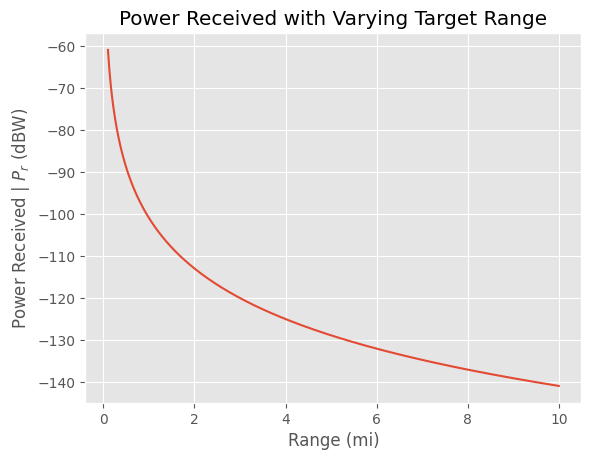

In [ ]:
R_miles = np.linspace(0.1, 10, 1000)
R = R_miles * mile

P_r = P_t * G_t_lin * rcs * effective_aperture / (16 * pi**2 * R**4)
P_r_db = lin2db(P_r)

fig, ax = plt.subplots()
ax.plot(R_miles, P_r_db)
ax.set_xlabel("Range (mi)")
ax.set_ylabel("Power Received | $P_r$ (dBW)")
ax.set_title("Power Received with Varying Target Range")
plt.show()

### Challenge Problem #3

What would the effective aperture, $A_e$, be for the [CHILL radar (link)](https://radarmet.atmos.colostate.edu/pdf/CHILLDescip.pdf) operating in its S-band mode?

Plot the received power over frequency (2 - 4 GHz) for this antenna with the target at a range of 1 mile.

For simplicity, you can just change the frequency, antenna aperture, and antenna gain, and keep the rest of the system parameters the same as Problem #1.

> Note: There are some issues with this.
For one, the amount of attenuation the signal will see as it propagates will depend on the medium. A clear sky, for example, will cause less attenuation than a sky with some precipitation.
For this exercise, there is no need to take this into account - it's not trivial to do so. If curious, though, you can check out the following resources:

- [Specific attenuation model for rain for use in prediction methods](https://www.itu.int/dms_pubrec/itu-r/rec/p/r-rec-p.838-3-200503-i!!pdf-e.pdf)
- [Propagation data and prediction methods required for the design of terrestrial line-of-sight systems](https://www.itu.int/dms_pubrec/itu-r/rec/p/R-REC-P.530-17-201712-S!!PDF-E.pdf)
- [Characteristics of precipitation for propagation modelling](https://www.itu.int/dms_pubrec/itu-r/rec/p/R-REC-P.837-7-201706-I!!PDF-E.pdf)

In [ ]:
# You can write the code to solve the problem here...

#### Expand this section for a hint

Look at Table 2 in the CHILL radar link above.

#### Solution


From the attached paper, you can find that the CHILL radar's antenna has a gain of 43 dB.
From here, you can simply plug this in for $G_t$ in the range equation and $G_r$ in the $A_e$ equation.

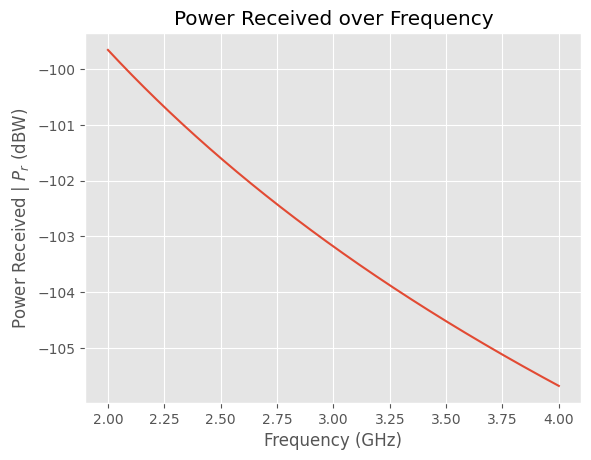

In [ ]:
P_t = 800e3  # W
G_t = 43  # dB
G_t_lin = db2lin(G_t)

R = 100e3  # m

f = np.linspace(2e9, 4e9, 1000)  # Sweeping frequency over S-band
wavelength = c / f

effective_aperture = G_t_lin * wavelength**2 / (4 * pi)

P_r = P_t * G_t_lin * rcs * effective_aperture / (16 * pi**2 * R**4)
P_r_db = lin2db(P_r)

fig, ax = plt.subplots()
ax.plot(f / 1e9, P_r_db)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Power Received | $P_r$ (dBW)")
ax.set_title("Power Received over Frequency")
plt.show()

## [02 - Signal-to-Noise Ratio (SNR)](https://tinyurl.com/radar-snr-vid)



![radar range equation thumbnail](https://drive.google.com/uc?id=1VumUe2tyN-sqG1SZ2Ep07PAoBcLCrVlu)

### Recreating example from [MIT Lincoln Lab lecture on the radar equation (slide 27)](https://tinyurl.com/mit-radar-equation).

In [ ]:
P_t = 1.4e6  # W
G_t_db = 33  # dBi
G_t = db2lin(G_t_db)  # linear factor

f = 2800e6  # Hz
wavelength = c / f  # m

# In the example problem, they approximate the wavelength to be 0.1 m, but this actually
# changes the answer by a good bit vs. actually computing the wavelength from frequency.
# Uncomment this next line if you want your numbers to line up with the lecture slides.
# wavelength = 0.1

R = 60 * nautical_mile  # m
rcs = 1  # m^2

k = Boltzmann  # J / K (Joules / Kelvin)
T = 950  # kelvin
bw = 1.67e6  # Hz

L_db = 8  # dB
L = db2lin(L_db)  # linear factor

N_pulses = 21

In [ ]:
signal_power = P_t * G_t**2 * wavelength**2 * rcs / ((4 * pi) ** 3 * R**4)
noise_power = k * T * bw * L
snr = signal_power / noise_power
snr_db = lin2db(snr)
print(f"SNR for a single pulse: {snr_db:.2f} dB")

snr_integrated_db = snr_db + 10 * np.log10(N_pulses)
print(f"SNR after integrating {N_pulses} pulses: {snr_integrated_db:.2f} dB")

SNR for a single pulse: 1.84 dB
SNR after integrating 21 pulses: 15.06 dB


### Challenge Problem #1

a.) Plot the SNR for a target that varies in range from $10 \le R \le 200$ km.

b.) At what range does the SNR drop below 0 dB?

In [ ]:
# You can write the code to solve the problem here...

#### Solution

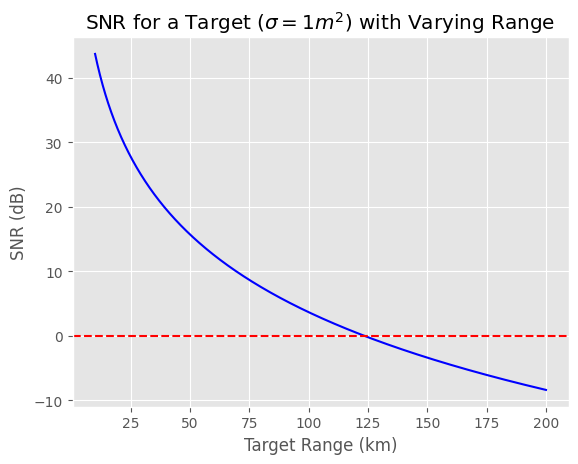

In [ ]:
R = np.linspace(10e3, 200e3, 1000)

signal_power = P_t * G_t**2 * wavelength**2 * rcs / ((4 * pi) ** 3 * R**4)
noise_power = k * T * bw * L
snr = signal_power / noise_power
snr_db = lin2db(snr)

fig, ax = plt.subplots()
ax.plot(R / 1e3, snr_db, c="b")
ax.set_xlabel("Target Range (km)")
ax.set_ylabel("SNR (dB)")
ax.set_title("SNR for a Target ($\\sigma = 1 m^2$) with Varying Range")
ax.axhline(0, c="r", linestyle="--")
plt.show()


In [ ]:
zero_crossing = R[np.argmin(np.abs(snr_db))]
print(f"SNR crosses below 0 dB after R = {zero_crossing/1e3:.2f} km")

SNR crosses below 0 dB after R = 123.54 km


## [03 - Resolution](https://tinyurl.com/resolution-video)

![reso thumbnail](https://drive.google.com/uc?id=1FozeKuvgJZduTpasCFBABVVR3nPMmR2-)

### Range Resolution
$\LARGE \Delta R = \frac{c \tau}{2} \approx \frac{c}{2B}$

In [ ]:
def compute_rres_tau(tau):
    return c * tau / 2


def compute_rres_bw(bw):
    return c / (2 * bw)

#### Using pulse width, $\tau$

In [ ]:
tau = 1e-6 # s
rres_tau = compute_rres_tau(tau)

print(
    f"For a tau of {tau * 1e6:.1f}us, you will get a range resolution of {rres_tau:.2f} m"
)

For a tau of 1.0us, you will get a range resolution of 149.90 m


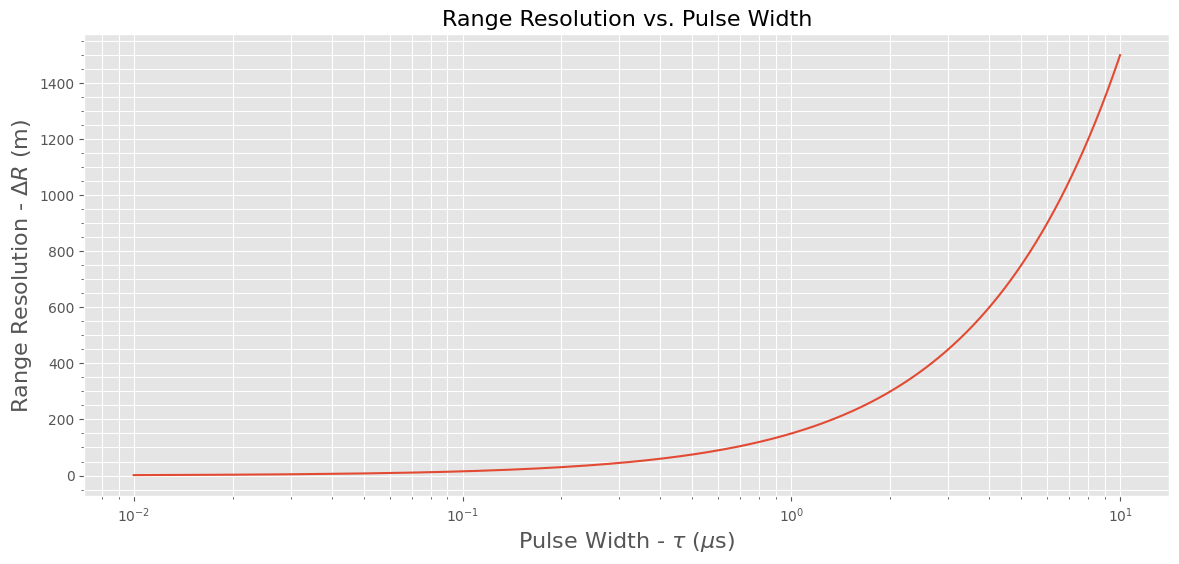

In [ ]:
taus = np.linspace(0.01e-6, 10e-6, 1000)
rres_taus = compute_rres_tau(taus)

fig = plt.figure(figsize=(14, 6))
plt.semilogx(taus * 1e6, rres_taus)
plt.xlabel(r"Pulse Width - $\tau$ ($\mu$s)", fontsize=16)
plt.ylabel(r"Range Resolution - $\Delta R$ (m)", fontsize=16)
plt.title("Range Resolution vs. Pulse Width", fontsize=16)
plt.grid(True, "both")
plt.minorticks_on()
plt.show()

#### Using bandwidth, $B$
For this example, I'll use an LFM modulated signal with a bandwidth, $B = 1$ MHz.

In [ ]:
# Radar setup
f = 77e9  # Hz
Tc = 1e-3  # chirp time - s
bw = 50e6  # Hz

chirp_rate = bw / Tc  # Hz/s
wavelength = c / f # m

In [ ]:
rres_bw = compute_rres_bw(bw)
print(
    f"For a bandwidth of {bw * 1e-6:.1f} MHz, you will get a range resolution of {rres_bw:.2f} m"
)

For a bandwidth of 50.0 MHz, you will get a range resolution of 3.00 m


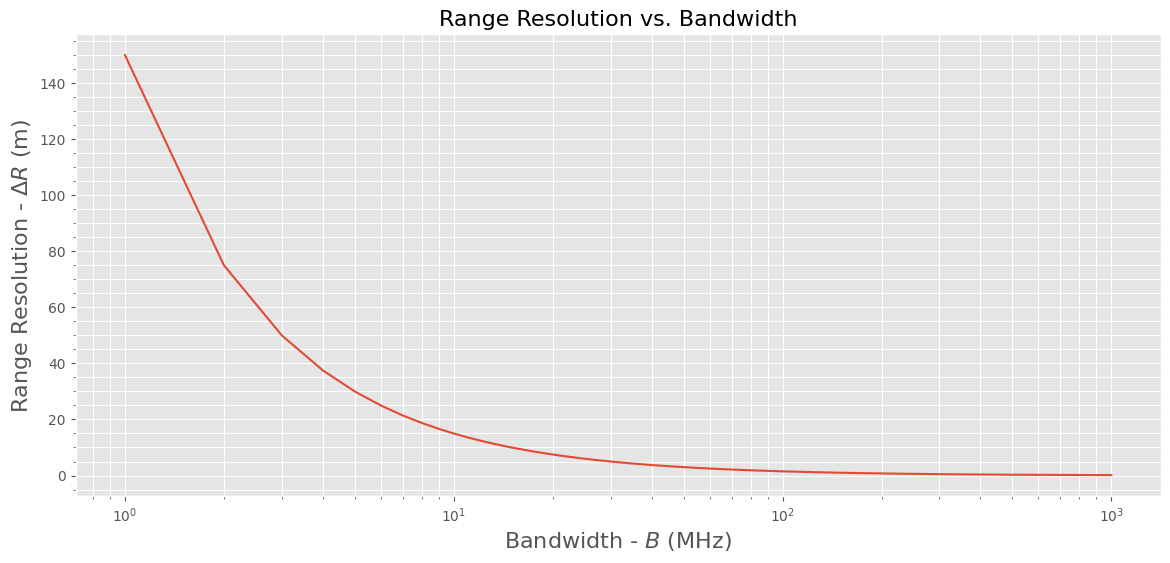

In [ ]:
bws = np.linspace(1e6, 1e9, 1000)
rres_bws = compute_rres_bw(bws)

fig = plt.figure(figsize=(14, 6))
plt.semilogx(bws / 1e6, rres_bws)
plt.xlabel(r"Bandwidth - $B$ (MHz)", fontsize=16)
plt.ylabel(r"Range Resolution - $\Delta R$ (m)", fontsize=16)
plt.title("Range Resolution vs. Bandwidth", fontsize=16)
plt.grid(True, "both")
plt.minorticks_on()
plt.show()

### Angular Resolution

We'll start by computing the array factor for a 1D uniformly spaced phased array (ULA - uniform linear array).
This shows how the number of elements impacts the beamwidth.

Try changing the `N` value and see how it affects the array factor's main lobe width.

In [ ]:
f_0 = 10e9  # center frequency for computing phase shifts (GHz)
wavelength_0 = c / f_0  # m
k_0 = 2 * pi / wavelength_0  # wave number
d_x = wavelength_0 / 2  # element spacing (m)

N = 4  # number of elements

theta = np.linspace(-pi, pi, 1000)  # theta values to plot over
u = np.sin(theta)  # theta in sine space

In [ ]:
def compute_af(weights, u_0):
    n = np.arange(weights.size)
    AF = np.sum(
        weights[:, None] * np.exp(1j * n[:, None] * d_x * k_0 * (u - u_0)), axis=0
    )
    AF /= AF.max()
    return AF

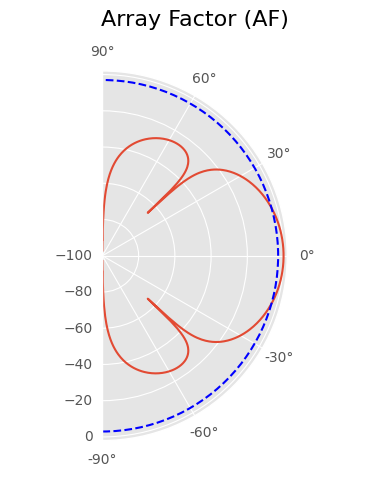

In [ ]:
AF = compute_af(
    signal.windows.kaiser(N, beta=2),
    np.sin(0),
)
plt.polar(theta, 20 * np.log10(np.abs(AF)))
plt.ylim(-100, 2)
plt.xlim(-pi / 2, pi / 2)
plt.title("Array Factor (AF)", fontsize=16, y=1.1)

# First side-lobe level for a rectangular (boxcar) window. See my video on phased array tapering if curious (https://tinyurl.com/tapering-video)
plt.axhline(-3, c="b", linestyle="--")

plt.show()

Why $R \sin({\theta}) \approx R \theta$

As can be seen from the graph, the approximation breaks down around $25^\circ$ or $30^\circ$.

<ipython-input-29-78e471b39c30>:9: RuntimeWarning: invalid value encountered in divide
  theta_deg, (np.abs(theta - sin) / theta) * 100, label="|Error|", c="y"


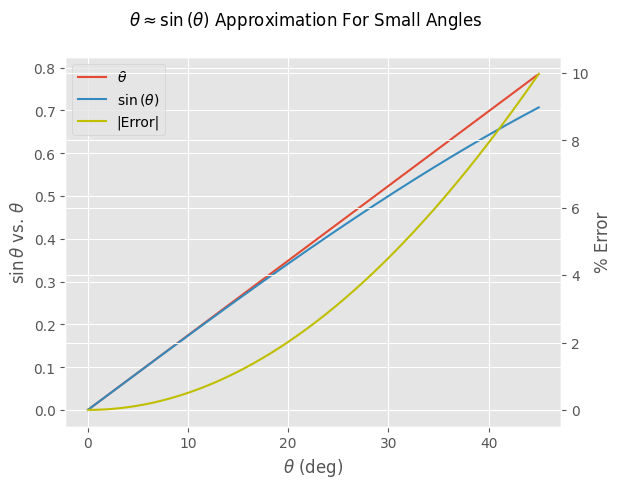

In [ ]:
theta = np.linspace(0, pi / 4, 1000)
theta_deg = np.linspace(0, 45, 1000)
sin = np.sin(pi * theta_deg / 180)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
(theta_line,) = ax1.plot(theta_deg, theta, label=r"$\theta$")
(sin_line,) = ax1.plot(theta_deg, sin, label=r"$\sin{(\theta)}$")
(error_line,) = ax2.plot(
    theta_deg, (np.abs(theta - sin) / theta) * 100, label="|Error|", c="y"
)
lines = [theta_line, sin_line, error_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")
ax1.set_ylabel(r"$\sin{\theta}$ vs. $\theta$")
ax2.set_ylabel(r"% Error")
ax1.set_xlabel(r"$\theta$ (deg)")
# labels = [
#     r"$0$",
#     r"$\frac{\pi}{16}$",
#     r"$\frac{\pi}{8}$",
#     r"$\frac{3\pi}{16}$",
#     r"$\frac{\pi}{4}$",
# ]

# ticks = np.linspace(0, np.pi / 4, 5)
# ax1.set_xticks(ticks)
# ax1.set_xticklabels(labels)
fig.suptitle(r"$\theta \approx \sin{(\theta)}$ Approximation For Small Angles")
plt.show()

### Velocity Resolution
- Doppler Velocity: $v = f_d \lambda / 2$
- Max Measurable Velocity: $v_{\text{max}} = \lambda / (4 T_c)$
- Velocity Resolution: $\Delta v = \lambda \text{PRF} / (2 M)$

#### Setup
Let's set this example up using parameters similar to that of an automotive radar.

This is actually the same setup used in the notebook made for my [video on FMCW Doppler](https://tinyurl.com/doppler-video-nb).

Try changing $M$ to see how this affects the output.

In [ ]:
# Radar setup
f = 77e9  # Hz
Tc = 40e-6  # chirp time - s
bw = 1.6e9  # bandwidth - Hz
chirp_rate = bw / Tc  # Hz/s

wavelength = c / f
M = 40  # number of chirps in coherent processing interval (CPI)

# Target
R = 20  # m
v = 10  # m/s

They can do this because they're operating at such a high center frequency that a bandwidth of 1.6 GHz is relatively small.

In [ ]:
range_resolution = c / (2 * bw)
print(f"Range resolution: {range_resolution:.2f} m")

Range resolution: 0.09 m


In [ ]:
def compute_vel_res(M):
    return wavelength / (2 * M * Tc)


max_vel = wavelength / (4 * Tc)
vel_res = compute_vel_res(M)

print(f"Maximum velocity: {max_vel:.2f} m/s")
print(f"Velocity resolution: {vel_res:.2f} m/s")

Maximum velocity: 24.33 m/s
Velocity resolution: 1.22 m/s


In [ ]:
def compute_phase_diff(v):
    time_from_vel = 2 * (v * Tc) / c
    return 2 * pi * f * time_from_vel


def compute_f_beat(R):
    return (2 * R * bw) / (c * Tc)


f_beat = compute_f_beat(R)
phase_diff = compute_phase_diff(v)

print(f"Beat frequency: {f_beat / 1e6:.2f} MHz")
print(f"Phase delta: {phase_diff:.2f} radians")

Beat frequency: 5.34 MHz
Phase delta: 1.29 radians


This is one of the $M$ received signals.

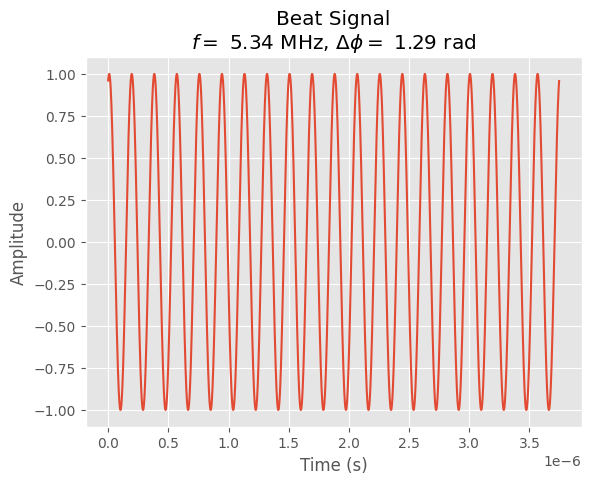

In [ ]:
max_time = 20 / f_beat
N = 10000
Ts = max_time / N
fs = 1 / Ts


t = np.arange(0, max_time, 1 / fs)

beat_signal = np.sin(2 * pi * compute_f_beat(R) * t + phase_diff)

plt.plot(t, beat_signal)
plt.title(
    f"Beat Signal\n"
    f"$f=\\ ${f_beat / 1e6:.2f} MHz, $\\Delta \\phi =\\ ${phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Taking this measurement $M$ times gives us the coherent processing interval (CPI).

In [ ]:
window = signal.windows.blackman(N)
cpi_single = np.array(
    [
        (
            np.sin(2 * pi * compute_f_beat(R) * t + m * phase_diff)
            + np.random.normal(0, 0.1, N)
        )
        * window
        for m in range(M)
    ]
)

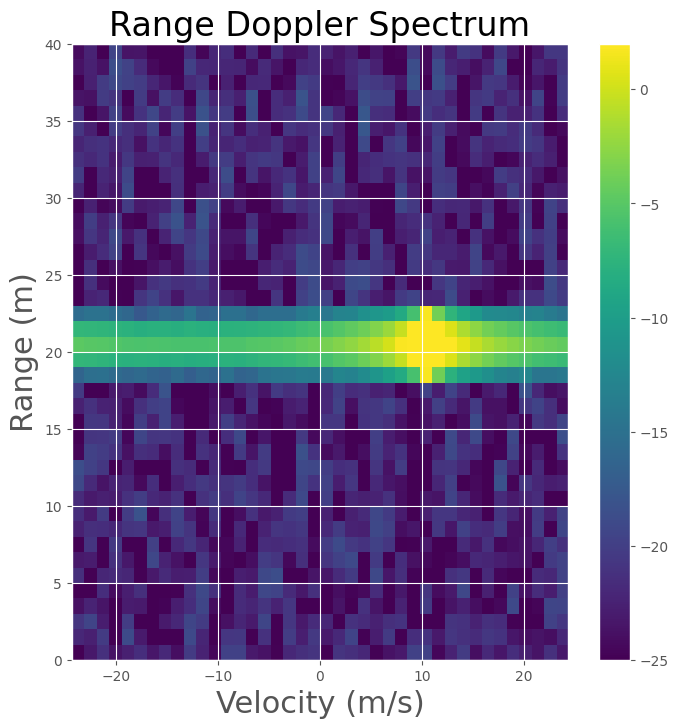

In [ ]:
vels = np.linspace(-max_vel, max_vel, M)
fft_len = N * 8
freq = np.linspace(-fs / 2, fs / 2, fft_len)

rmax = c * Tc * fs / (2 * bw)
ranges = np.linspace(-rmax / 2, rmax / 2, fft_len)

range_doppler = fftshift(np.abs(fft2(cpi_single.T))) / (N / 2)

extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

fig, ax = plt.subplots(figsize=(8, 8))
range_doppler_plot = ax.imshow(
    10 * np.log10(range_doppler),
    aspect="auto",
    extent=extent,
    origin="lower",
    vmax=2,
    vmin=-25,
)
ax.set_ylim([0, 40])
ax.set_title("Range Doppler Spectrum", fontsize=24)
ax.set_xlabel("Velocity (m/s)", fontsize=22)
ax.set_ylabel("Range (m)", fontsize=22)
fig.colorbar(range_doppler_plot)
plt.show()

Increasing $M$ increases the amount of time spent taking measurements which is something we often want to minimize so we can move to other areas and take more measurements (other reasons too).
This plot shows how you have a trade-off between making the velocity resolution more fine and increasing measurement time (increasing $M$).

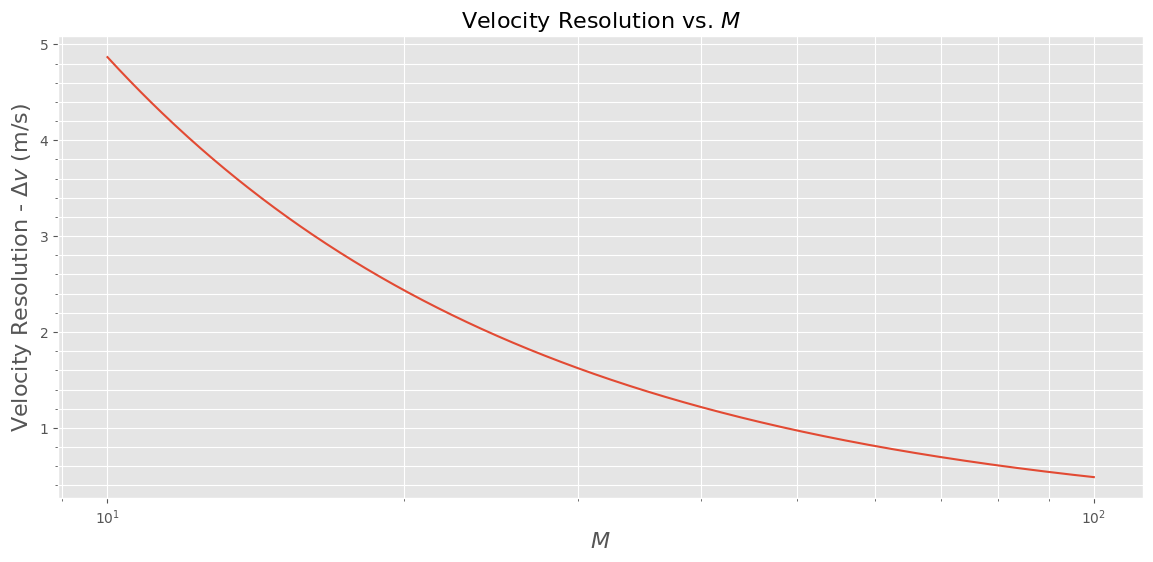

In [ ]:
Ms = np.linspace(10, 100, 1000)
vel_ress = compute_vel_res(Ms)

fig = plt.figure(figsize=(14, 6))
plt.semilogx(Ms, vel_ress)
plt.xlabel(r"$M$", fontsize=16)
plt.ylabel(r"Velocity Resolution - $\Delta v$ (m/s)", fontsize=16)
plt.title("Velocity Resolution vs. $M$", fontsize=16)
plt.grid(True, "both")
plt.minorticks_on()
plt.show()